## Setup

In [43]:
source("2022_PSVD_metabolomics/2022_PSVD_metabolomics/R/00_setup.R")

In [44]:
p_load("dplyr", "ggplot2", install = FALSE)

In [45]:
metabolites <- read.csv("outputs/01_metabolomics_merged_outliers.csv")

In [46]:
metabolites_gp <- read.csv("data/validation/metabolite_counts_gp.csv")
meta_gp <- read.csv("data/validation/metadata_gp.csv")

In [47]:
# Create a mapping vector
#mapping_vector <- setNames(meta_gp$INDIVIDUAL.NOTATION, meta_gp$OWLID)
mapping_vector <- sapply(meta_gp$OWLID, function(owlid) {
  hmdb_code <- meta_gp$INDIVIDUAL.NOTATION[meta_gp$OWLID == owlid]
  fallback_value <- meta_gp$OWLID[meta_gp$OWLID == owlid]

  if (!is.na(hmdb_code) && hmdb_code != "") {
    return(hmdb_code)
  } else {
    return(fallback_value)
  }
})

In [48]:
colnames(metabolites_gp)[4:ncol(metabolites_gp)] <- mapping_vector[colnames(metabolites_gp)[4:ncol(metabolites_gp)]]



In [49]:
rename_duplicates <- function(df) {
  cols <- names(df)
  duplicated_cols <- duplicated(cols)
  cols[duplicated_cols] <- paste0(cols[duplicated_cols], "_2")
  names(df) <- cols
  return(df)
}

metabolites_gp <- rename_duplicates(metabolites_gp)


In [50]:
long <- metabolites_gp %>%
  tidyr::gather(key = "parameter", value = "value", -c(1:3)) 


Warning message:
“Removed 123 rows containing non-finite values (`stat_density()`).”


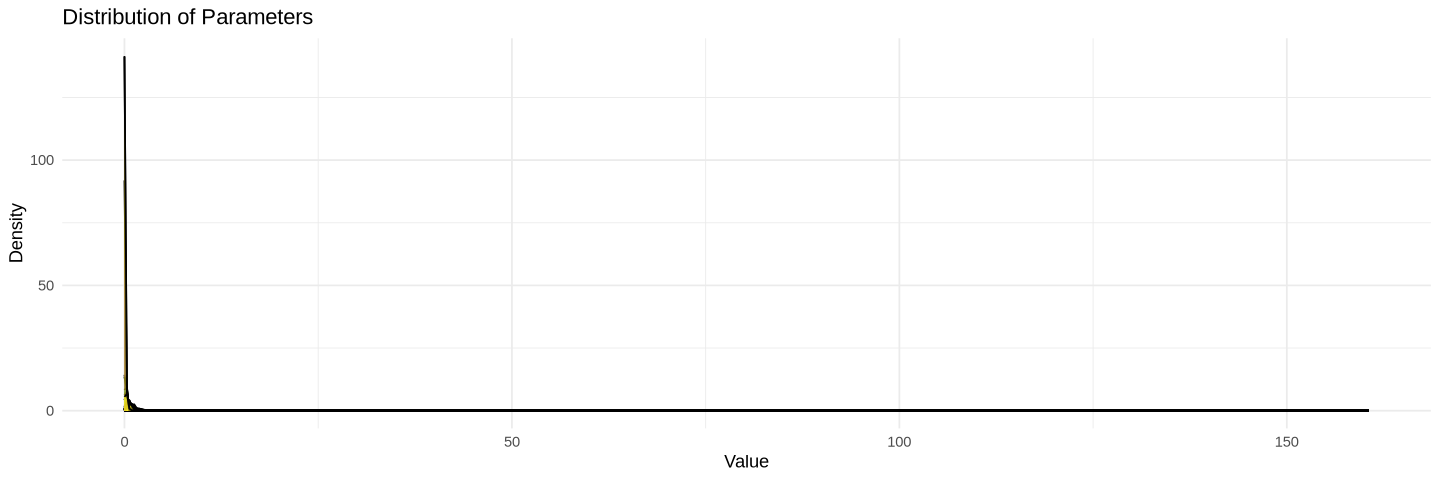

In [51]:
ggplot(long, aes(x = value, fill = parameter)) +
  geom_density(alpha = 0.5) +
  scale_fill_viridis_d() +  
  theme_minimal() +
  labs(x = "Value", y = "Density", title = "Distribution of Parameters") +
  theme(legend.position = "none")


In [52]:
metabolites_gp <- metabolites_gp %>% filter(!OWL.code %in% c("Owl-IPH-001",
                                            "Owl-IPH-005",
                                            "Owl-IPH-006",
                                            "Owl-IPH-009",
                                            "Owl-IPH-014",
                                            "Owl-IPH-015",
                                            "Owl-IPH-022",
                                            "Owl-IPH-023",
                                            "Owl-IPH-024",
                                            "Owl-IPH-026",
                                            "Owl-IPH-028",
                                            "Owl-IPH-030",
                                            "Owl-IPH-031",
                                            "Owl-IPH-033",
                                            "Owl-IPH-035",
                                            "Owl-IPH-040",
                                            "Owl-IPH-073",
                                            "Owl-IPH-071",
                                            "Owl-IPH-104"))

In [53]:
meta <- metabolites_gp %>% select(c(OWL.code, GRUPO))
mtx <- metabolites_gp %>% select(-c(subgrupo.de.CIRROSIS..para.comparacion.NR.vs.R., GRUPO))

In [54]:
meta$GRUPO <- as.factor(meta$GRUPO)

In [55]:
length((meta %>% filter(GRUPO %in% "IPH"))$GRUPO)

[1] 32

In [56]:
colnames(mtx) <- janitor::make_clean_names(colnames(mtx))

## Normalization

In [57]:
library(POMA)

In [58]:
gp_se <- PomaSummarizedExperiment(target = meta, features = mtx[2:ncol(mtx)])


In [59]:
gp_se <- gp_se %>% PomaNorm(method = "log_pareto")

In [60]:
mtx_norm <- t(SummarizedExperiment::assay(gp_se))

In [61]:
mtx_norm <- mtx_norm[, !colSums(is.na(mtx_norm))]

In [62]:
long <- mtx_norm %>% as.data.frame() %>%
  tidyr::gather(key = "parameter", value = "value")  


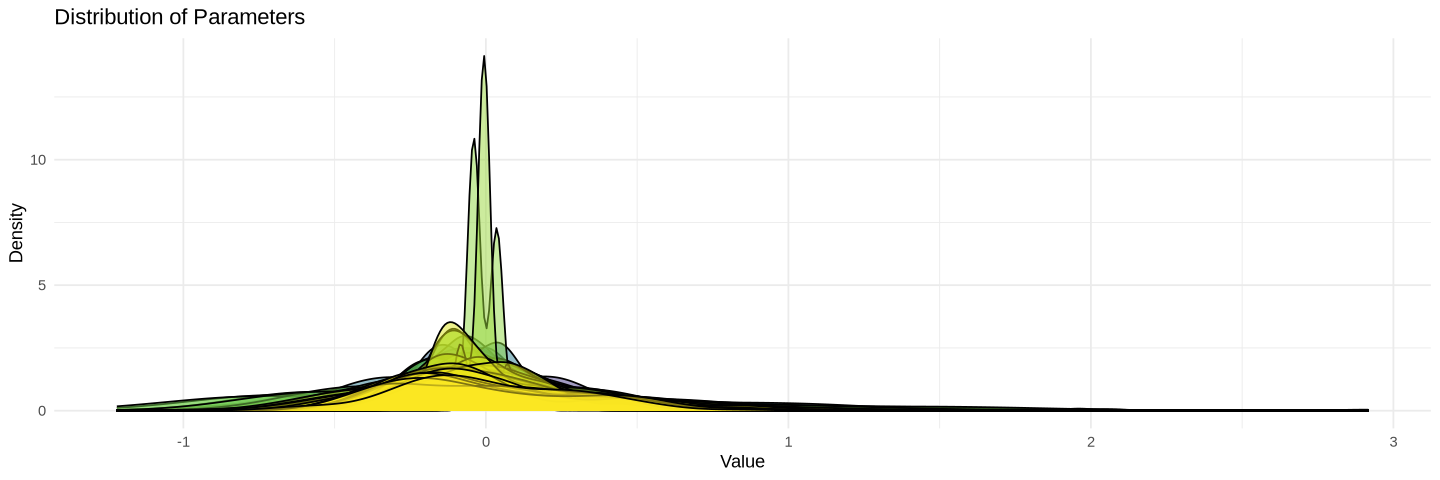

In [63]:
ggplot(long, aes(x = value, fill = parameter)) +
  geom_density(alpha = 0.5) +
  scale_fill_viridis_d() + 
  theme_minimal() +
  labs(x = "Value", y = "Density", title = "Distribution of Parameters") +
  theme(legend.position = "none")


## DimRed

In [64]:
library(PCAtools)

Loading required package: ggrepel




Attaching package: ‘PCAtools’


The following objects are masked from ‘package:stats’:

    biplot, screeplot




In [65]:
pca_mt <- mtx_norm %>% t()

In [66]:
pca_meta <- meta %>% tibble::column_to_rownames("OWL.code")

In [67]:
p <- pca(pca_mt, metadata = pca_meta, removeVar = 0.5)

-- removing the lower 50% of variables based on variance



Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


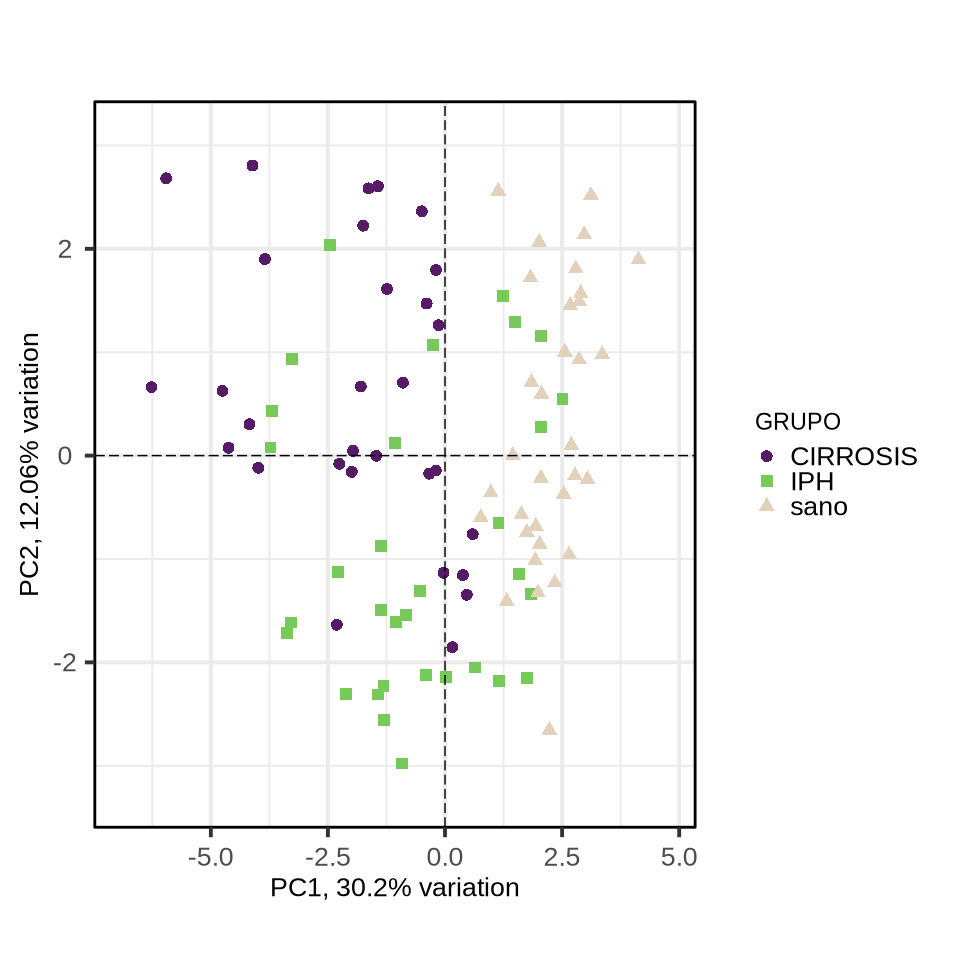

In [68]:
options(repr.plot.width = 8, repr.plot.height = 8)


biplot(p, lab = NULL, colby = "GRUPO", colkey = c("CIRROSIS" = "#571a66", "IPH" = "#77c95a", "sano" = "#e2d1bb"), hline = 0, vline = 0, legendPosition = "right", legendLabSize = 16,
  legendIconSize = 3, shape = "GRUPO", shapekey = c("CIRROSIS" = 16, "IPH" = 15, "sano" = 17))

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


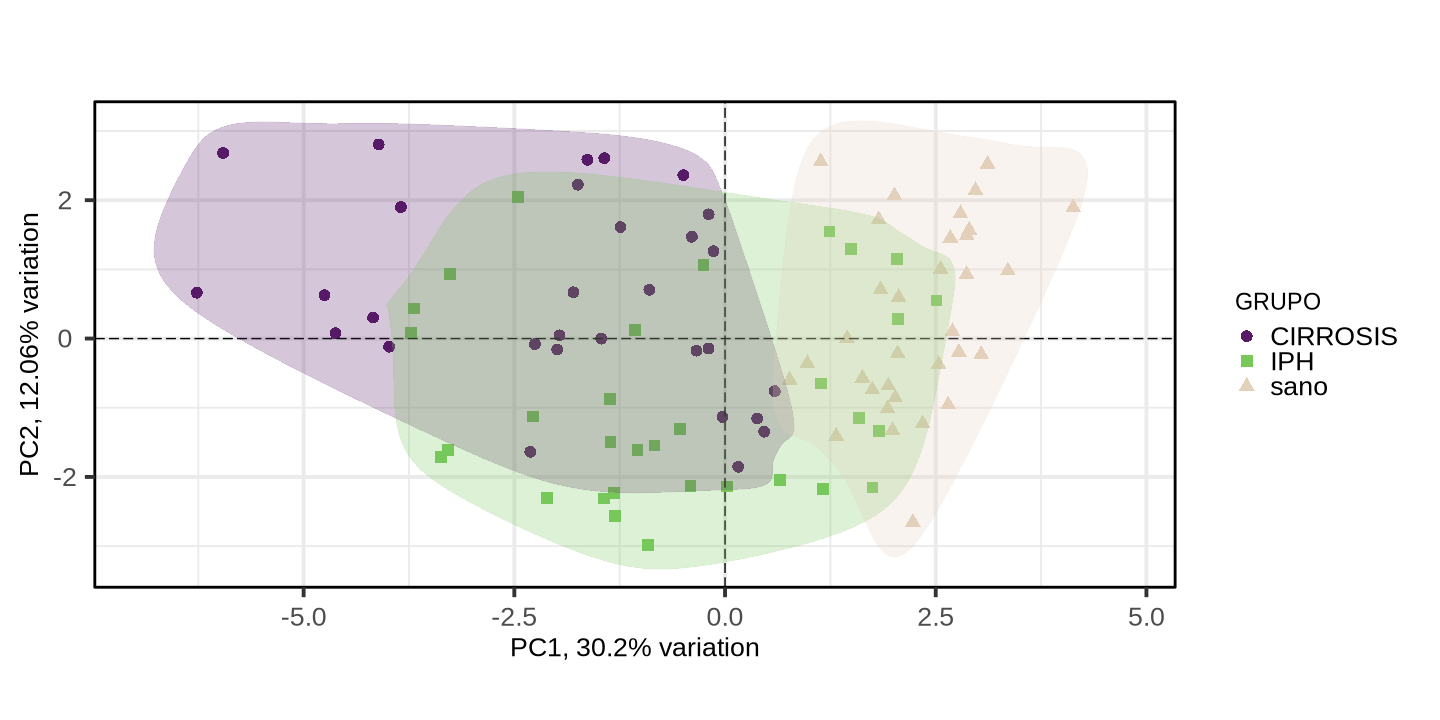

In [70]:
options(repr.plot.width = 12, repr.plot.height = 6)

biplot(p, lab = NULL, colby = "GRUPO", colkey = c("CIRROSIS" = "#571a66", "IPH" = "#77c95a", "sano" = "#e2d1bb"), hline = 0, vline = 0, legendPosition = "right", legendLabSize = 16,
  legendIconSize = 3, shape = "GRUPO", shapekey = c("CIRROSIS" = 16, "IPH" = 15, "sano" = 17), encircle = TRUE, encircleFill = TRUE)

-- variables retained:

cho_e_22_6, pc_15_0_22_6, pc_18_3_18_3, pc_20_3_20_4, cer_d43_1, cer_40_2, pc_18_2_20_4, pc_15_0_20_4, taurocholic_acid, taurochenodeoxycholic_acid, pe_20_5_16_0, pc_16_0_20_5, glycoursodeoxycholic_acid, ac15

Warning message:
“ggrepel: 6 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


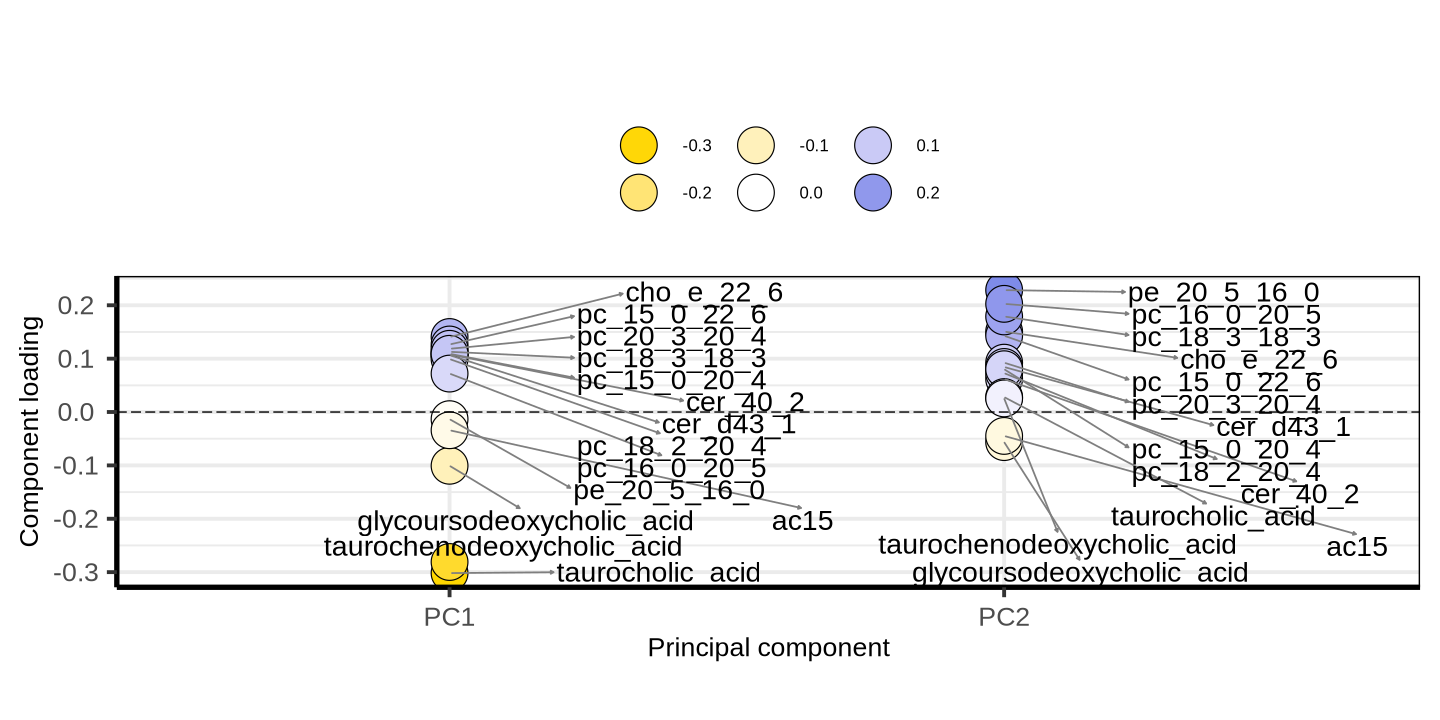

In [72]:
 plotloadings(p, components = getComponents(p, c(1, 2)), 
                rangeRetain = 0.1, labSize = 6)

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Coordinate system already present. Adding new coordinate system, which will
replace the existing one.
Coordinate system already present. Adding new coordinate system, which will
replace the existing one.
Coordinate system already present. Adding new coordinate system, which will
replace the existing one.
Coordinate system already present. Adding new coordinate system, which will
replace the existing one.
Coordinate system already present. Adding new coordinate system, which will
replace the existing one.
Coordinate system already present. Adding new coordinate system, which will
replace the existing one.
Coordinate system already present. Adding new coordinate syst

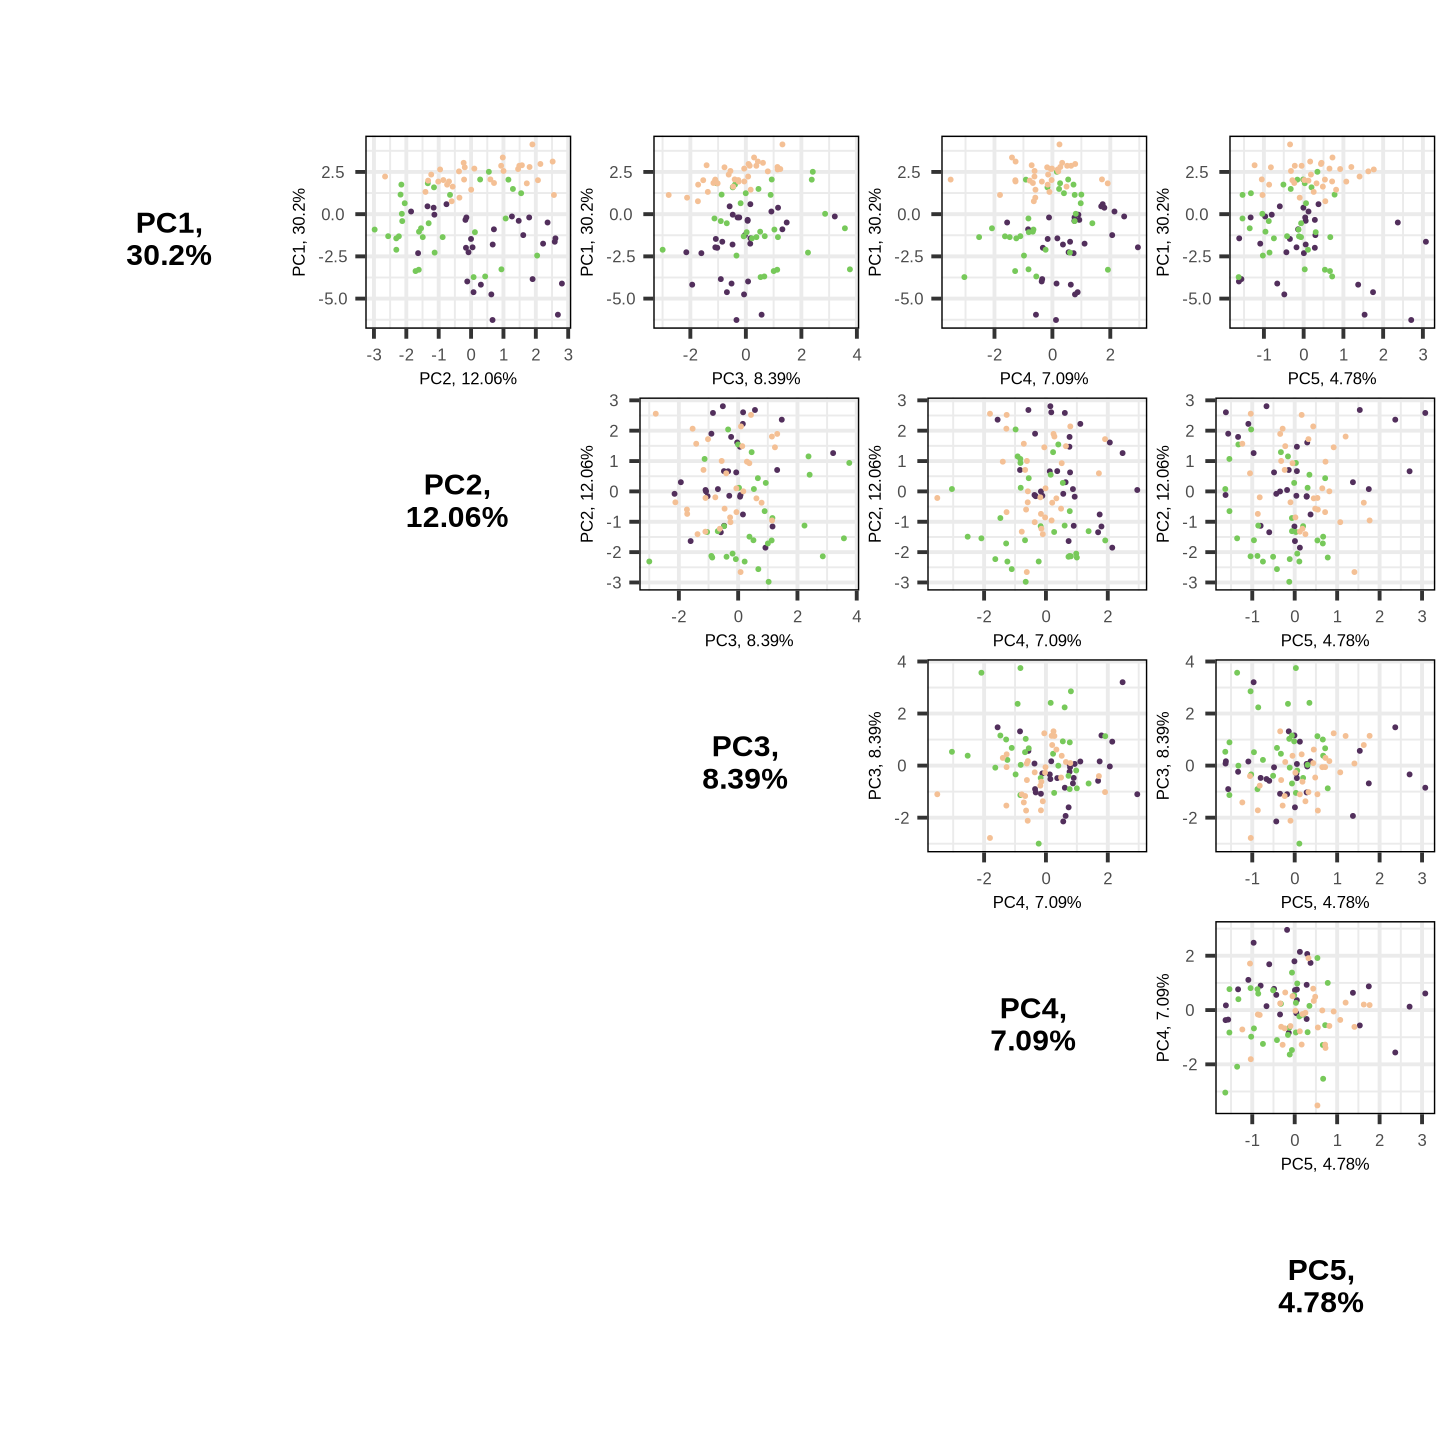

In [73]:
options(repr.plot.width = 12, repr.plot.height = 12)
 pairsplot(p, colby = 'GRUPO', 
            colkey = c(CIRROSIS = "#522f5c",
  IPH = "#77c95a", sano = "#F4C095")) 

In [74]:
length(rownames(p$metadata))

[1] 95

## HeatMap

In [75]:
metabolites_renamed <- SummarizedExperiment::assay(gp_se) %>% as.data.frame() #%>% tibble::rownames_to_column("X")

In [78]:
ann <- metabolites_gp %>% dplyr::select(c(OWL.code, GRUPO)) %>% dplyr::rename(sample_description = OWL.code)
#mat <- mtx %>% tibble::column_to_rownames("owl_code") %>% t()
mat <- metabolites_renamed

In [79]:
vars <- apply(mat, 1, var)
top_20_indices <- order(vars, decreasing=TRUE)[1:20]
mat <- mat[top_20_indices, ]

In [80]:
ann_cir <- ann %>% filter(GRUPO == "CIRROSIS")
ann_psvd <- ann %>% filter(GRUPO == "IPH")
ann_cneg <- ann %>% filter(GRUPO == "sano")
mat_cir <- mat %>% as.data.frame() %>% select(any_of(as.character(ann_cir$sample_description)))

mat_psvd <- mat %>% as.data.frame() %>% select(any_of(as.character(ann_psvd$sample_description)))

mat_control <- mat %>% as.data.frame() %>% select(any_of(as.character(ann_cneg$sample_description)))
mat_cir <- mat_cir %>% mutate(cir_mean = rowMeans(mat_cir)) %>% select(cir_mean)

mat_psvd <- mat_psvd %>% mutate(psvd_mean = rowMeans(mat_psvd)) %>% select(psvd_mean)

mat_control <- mat_control %>% mutate(ctrl_mean = rowMeans(mat_control)) %>% select(ctrl_mean)
mat_means <- cbind(mat_cir, mat_psvd, mat_control) 

In [81]:
mat_means

,cir_mean,psvd_mean,ctrl_mean
,<dbl>,<dbl>,<dbl>
taurocholic_acid,0.55883333,0.25662500,-0.756939394
taurochenodeoxycholic_acid,0.53076667,0.22162500,-0.697424242
tauroursodeoxycholic_taurohyodeoxycholic_acid,0.28300000,0.33778125,-0.584727273
glycocholic_acid,0.38126667,0.24368750,-0.582969697
taurolithocholic_acid,0.32203333,0.12312500,-0.412242424
glycoursodeoxycholic_acid,0.01206667,0.32790625,-0.328878788
chenodeoxycholic_acid,-0.02493333,0.20978125,-0.180696970
glycochenodeoxycholic_acid,0.23763333,0.25940625,-0.467424242
ac13,-0.18376667,0.02731250,0.140636364


In [82]:
library(pheatmap)

In [83]:
mat_means <- na.omit(mat_means)

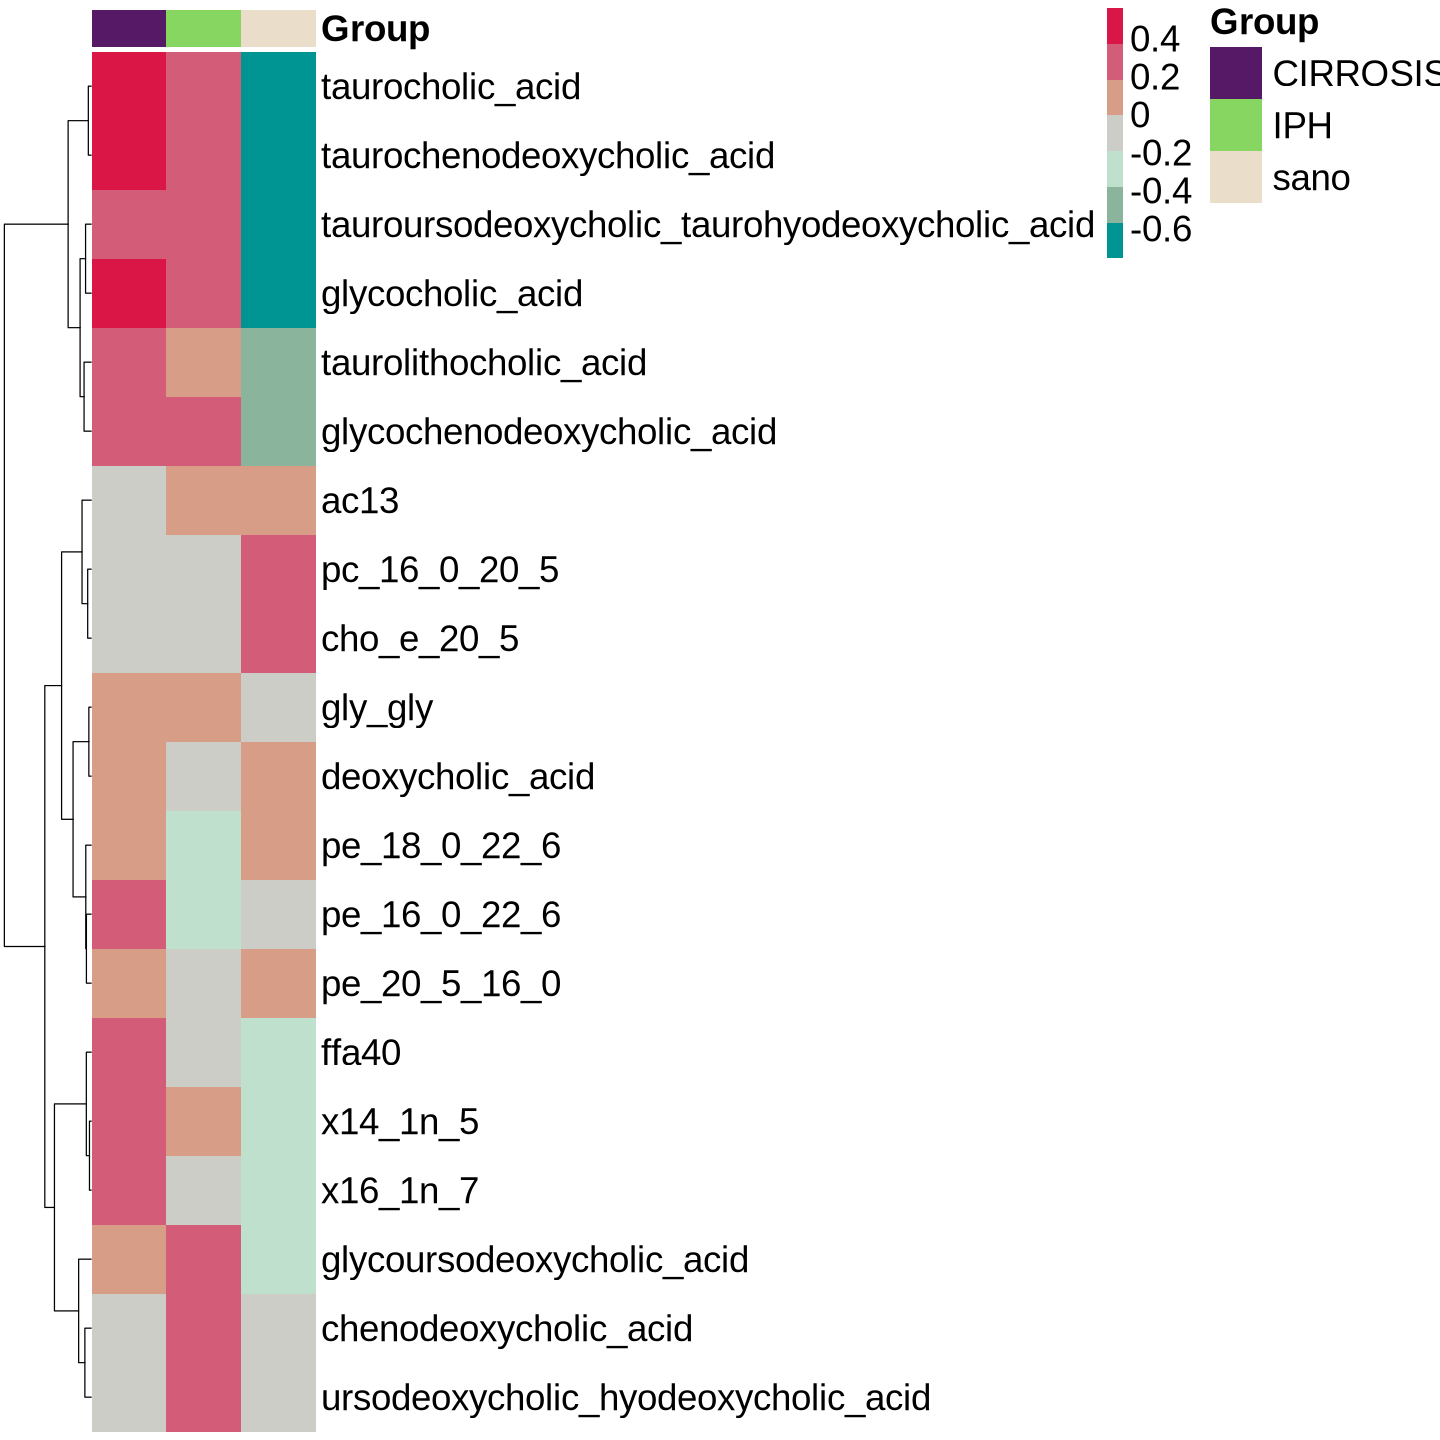

In [84]:
options(repr.plot.width = 12, repr.plot.height = 12)

annotation <- data.frame(rownames = colnames(mat_means), Group = c("CIRROSIS", "IPH", "sano")) %>% tibble::column_to_rownames("rownames")


ann_colors <- list(Group = c('CIRROSIS' = "#561965", 'IPH' = "#87d662", 'sano' = "#EADDCA"))

#mat <- mat[, (row.names(ann))]

F1_A <- pheatmap(mat_means %>% as.matrix(),  color = c("#009593", "#8AB49B", "#bfe0cc", "#CCCDC6", "#D79D86", "#D35C79", "#d91645"), cluster_rows = TRUE,
  show_rownames = TRUE, cluster_cols = F,
  show_colnames = FALSE, annotation_col = annotation, annotation_colors = ann_colors, clustering_method = "ward.D2", clustree_rows = 3, fontsize = 22)

## Differential metabolites

In [85]:
library(EnhancedVolcano)

In [86]:
iph_sano <- PomaLimma(gp_se, contrast  = "IPH-sano", adjust = "fdr")
iph_cirrhosis <- PomaLimma(gp_se, contrast  = "IPH-CIRROSIS", adjust = "fdr")

In [87]:
iph_sano %>% filter(adj.P.Val < 0.05) %>% select(-feature) %>% arrange(adj.P.Val) %>% arrange(desc(logFC))

ID,logFC,AveExpr,t,P.Value,adj.P.Val,B
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
taurocholic_acid,1.0135644,-2.105263e-05,7.363602,5.342475e-11,3.047536e-09,14.53181305
tauroursodeoxycholic_taurohyodeoxycholic_acid,0.9225085,3.157895e-05,7.342991,5.903241e-11,3.047536e-09,14.43365436
taurochenodeoxycholic_acid,0.9190492,-2.300791e-18,7.187198,1.252249e-10,4.025087e-09,13.69433361
glycocholic_acid,0.8266572,-2.105263e-05,7.418620,4.091441e-11,3.047536e-09,14.79422048
glycochenodeoxycholic_acid,0.7268305,5.263158e-05,7.098092,1.921367e-10,5.403845e-09,13.27367256
glycoursodeoxycholic_acid,0.6567850,2.105263e-05,5.699322,1.237893e-07,1.638388e-06,6.94244294
taurolithocholic_acid,0.5353674,-3.157895e-05,4.389569,2.840686e-05,2.084250e-04,1.68478695
chenodeoxycholic_acid,0.3904782,2.105263e-05,3.085945,2.629971e-03,9.245992e-03,-2.58617336
cystine_double_charge,0.3170360,-1.052632e-05,3.506362,6.838516e-04,3.273758e-03,-1.33350539


In [88]:
iph_cirrhosis %>% filter(adj.P.Val < 0.05) %>% select(-feature) %>% arrange(adj.P.Val) %>% arrange(desc(logFC))

ID,logFC,AveExpr,t,P.Value,adj.P.Val,B
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ursodeoxycholic_hyodeoxycholic_acid,0.3389417,-1.052632e-05,2.752868,7.026134e-03,0.0254980685,-3.3949672
glycoursodeoxycholic_acid,0.3158396,2.105263e-05,2.675661,8.725967e-03,0.0293036197,-3.5904608
pc_18_2_20_4,0.2363771,4.210526e-05,3.572912,5.468072e-04,0.0032376744,-1.0374217
pc_18_2_18_2,0.2336792,-1.052632e-05,2.920143,4.330808e-03,0.0170952942,-2.9551830
glutamine,0.2066854,-1.052632e-05,3.508851,6.781888e-04,0.0039126274,-1.2391601
glycine,0.2043458,-2.105263e-05,4.216021,5.495048e-05,0.0005151608,1.1368324
ac_18_2n_6,0.2026875,4.210526e-05,3.249754,1.577617e-03,0.0069600757,-2.0257025
asparagine,0.1936375,-1.052632e-05,3.395616,9.860526e-04,0.0049302628,-1.5887784
ac08,0.1935729,1.052632e-05,2.619819,1.017925e-02,0.0332096475,-3.7288579


In [89]:
library("EnhancedVolcano")

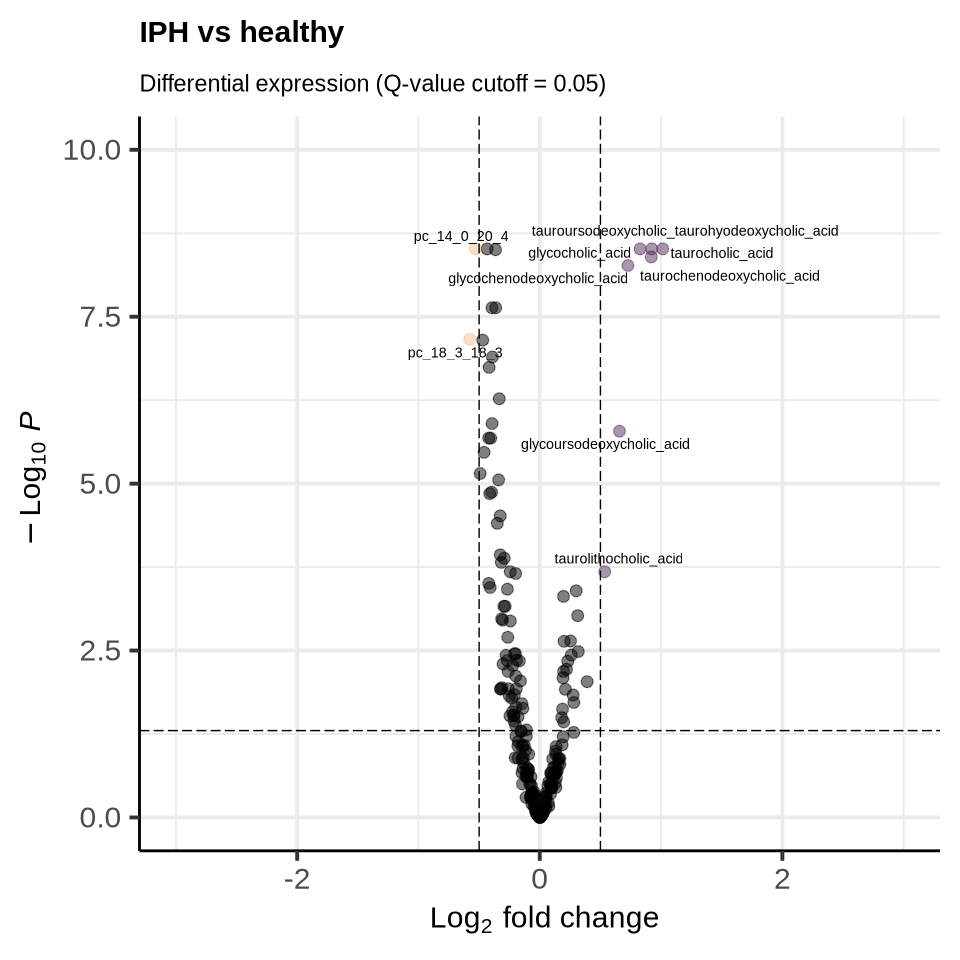

In [90]:
options(repr.plot.width = 8, repr.plot.height = 8)

keyvals <- rep("#000000", nrow(iph_sano))
names(keyvals) <- rep("NS", nrow(iph_sano))

keyvals[which(iph_sano$logFC >= 0.5 &
                iph_sano$`adj.P.Val` < 0.05)] <- "#522f5c"
names(keyvals)[which(iph_sano$logFC >= 0.5 &
                       iph_sano$`adj.P.Val` < 0.05)] <- "Cirrhosis"
keyvals[which(iph_sano$logFC <= -0.5 &
                iph_sano$`adj.P.Val` <= 0.05)] <- "#F4C095"
names(keyvals)[which(iph_sano$logFC <= -0.5 &
                       iph_sano$`adj.P.Val` <= 0.05)] <- "Non-diseased"
     


EnhancedVolcano(iph_sano,
                lab = iph_sano$ID,
                colCustom = keyvals,
                x = "logFC",
                y = "adj.P.Val",
                ylim = c(0, 10),
                xlim = c(-3, 3),
                title = expression(bold("IPH vs healthy")),
                subtitle = "Differential expression (Q-value cutoff = 0.05)",
                caption = NULL,
                pCutoff = 0.05,
                FCcutoff = 0.5,
                pointSize = 3.0,
                labSize = 3.0,
                drawConnectors = TRUE,
                widthConnectors = 0.15,
                max.overlaps = 12, min.segment.length = 1
               ) + theme(legend.position = "none")

Warning message:
“ggrepel: 52 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


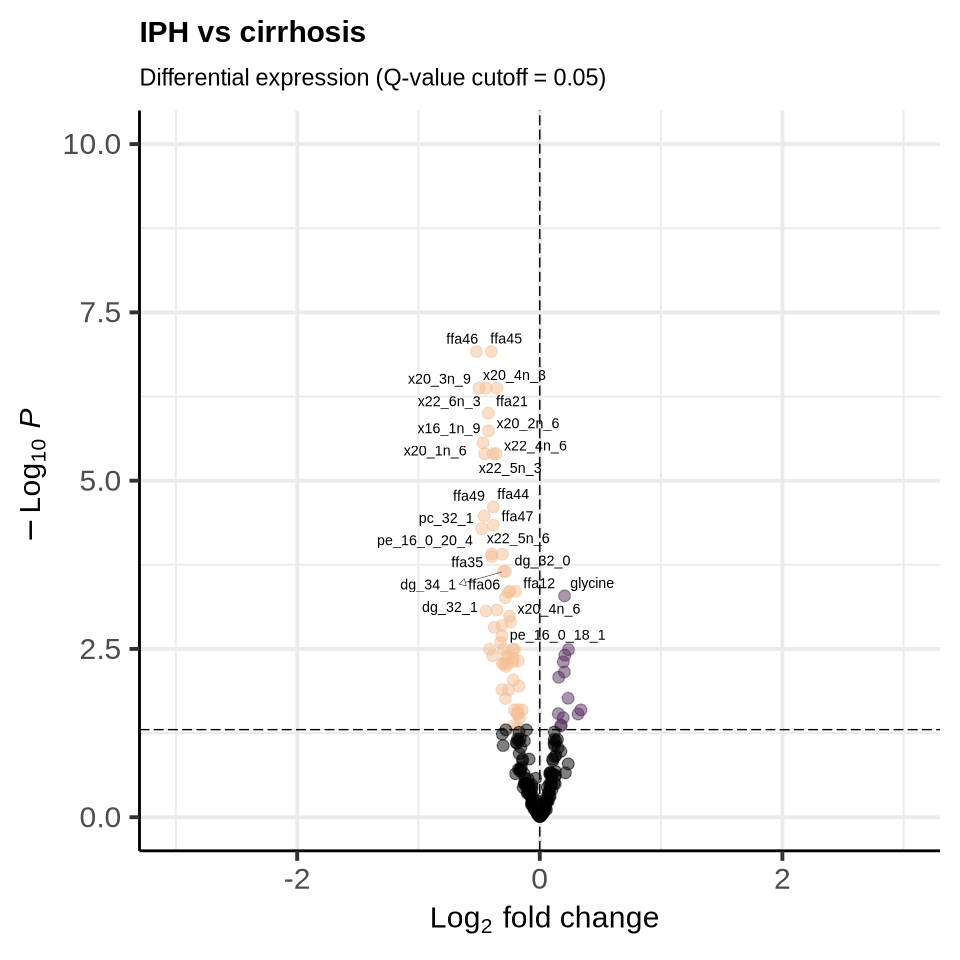

In [91]:
keyvals <- rep("#000000", nrow(iph_cirrhosis))
names(keyvals) <- rep("NS", nrow(iph_cirrhosis))

keyvals[which(iph_cirrhosis$logFC >= 0.001 &
                iph_cirrhosis$`adj.P.Val` < 0.05)] <- "#522f5c"
names(keyvals)[which(iph_cirrhosis$logFC >= 0.001 &
                       iph_cirrhosis$`adj.P.Val` < 0.05)] <- "Cirrhosis"
keyvals[which(iph_cirrhosis$logFC <= -0.001 &
                iph_cirrhosis$`adj.P.Val` <= 0.05)] <- "#F4C095"
names(keyvals)[which(iph_cirrhosis$logFC <= -0.001 &
                       iph_cirrhosis$`adj.P.Val` <= 0.05)] <- "Non-diseased"
     


EnhancedVolcano(iph_cirrhosis,
                lab = iph_cirrhosis$ID,
                colCustom = keyvals,
                x = "logFC",
                y = "adj.P.Val",
                ylim = c(0, 10),
                xlim = c(-3, 3),
                title = expression(bold("IPH vs cirrhosis")),
                subtitle = "Differential expression (Q-value cutoff = 0.05)",
                caption = NULL,
                pCutoff = 0.05,
                FCcutoff = 0,
                pointSize = 3.0,
                labSize = 3.0,
                drawConnectors = TRUE,
                widthConnectors = 0.15,
                max.overlaps = 12, min.segment.length = 1
               ) + theme(legend.position = "none")

## Functional analysis

In [93]:
library("pathview")



##############################################################################
Pathview is an open source software package distributed under GNU General
Public License version 3 (GPLv3). Details of GPLv3 is available at
http://www.gnu.org/licenses/gpl-3.0.html. Particullary, users are required to
formally cite the original Pathview paper (not just mention it) in publications
or products. For details, do citation("pathview") within R.

The pathview downloads and uses KEGG data. Non-academic uses may require a KEGG
license agreement (details at http://www.kegg.jp/kegg/legal.html).
##############################################################################



In [94]:
iph_cirr_pathway <- read.csv("outputs/06_iph_cirr_pathways.csv")
iph_healthy_pathway <- read.csv("outputs/06_iph_healthy_pathways.csv")

In [95]:
cir_cneg_sig <- iph_healthy_pathway %>% filter(FDR < 0.25) %>% arrange(FDR) #%>% head(15) %>% knitr::kable(caption = "Top 10 enriched pathways in CIR/CNEG") #%>% knitr::kable_styling(bootstrap_options = "striped", full_width = F)

cir_cneg_sig$source <- "CIR"

psvd_cneg_sig <- iph_cirr_pathway %>% filter(FDR < 0.25) %>% arrange(FDR) #%>% head(15) %>% knitr::kable(caption = "Top 10 enriched pathways in PSVD/CNEG") #%>% knitr::kable_styling(bootstrap_options = "striped", full_width = F)

psvd_cneg_sig$source <- "PSVD"

In [98]:
combined_pathways <- rbind(cir_cneg_sig, psvd_cneg_sig)

duplicate_pathways <- combined_pathways %>% janitor::get_dupes(X)

combined_pathways <- combined_pathways %>% mutate(source = case_when(X %in% duplicate_pathways$X ~ "both", TRUE ~ (as.character(source))))

mean_impact <- combined_pathways %>% group_by(X) %>% summarise_at(vars(matches("Impact")), mean)

combined_pathways <- combined_pathways %>% distinct(X, .keep_all = TRUE) %>% arrange(X) %>% mutate(Impact = mean_impact$Impact) %>% arrange(FDR)

#pathways_names <- pathways_names %>% filter(V1 %in% combined_pathways$X)

#pathways_names <- pathways_names %>% arrange(V1)

#combined_pathways_mapped <- combined_pathways %>% arrange(X) %>% mutate(X = pathways_names$V2) %>% arrange(FDR)

No duplicate combinations found of: X



In [99]:
combined_pathways

X,Total,Expected,Hits,Raw.p,X.log10.p.,Holm.adjust,FDR,Impact,source
<chr>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Biosynthesis of unsaturated fatty acids,36,0.41143,8,1.2226e-09,8.9127,9.7809e-08,9.7809e-08,0.00000,PSVD
Primary bile acid biosynthesis,46,0.64254,7,1.3935e-06,5.8559,1.1148e-04,1.1148e-04,0.09387,CIR
Taurine and hypotaurine metabolism,8,0.11175,3,1.2679e-04,3.8969,1.0016e-02,5.0715e-03,0.82857,CIR
Glyoxylate and dicarboxylate metabolism,32,0.36571,3,5.0563e-03,2.2962,3.9945e-01,2.0225e-01,0.14815,PSVD
Arginine biosynthesis,14,0.16000,2,1.0354e-02,1.9849,7.9723e-01,2.0707e-01,0.22843,PSVD
alpha-Linolenic acid metabolism,13,0.14857,2,8.9349e-03,2.0489,6.9692e-01,2.0707e-01,0.33333,PSVD
Fatty acid biosynthesis,47,0.53714,3,1.4842e-02,1.8285,1.0000e+00,2.3747e-01,0.01473,PSVD


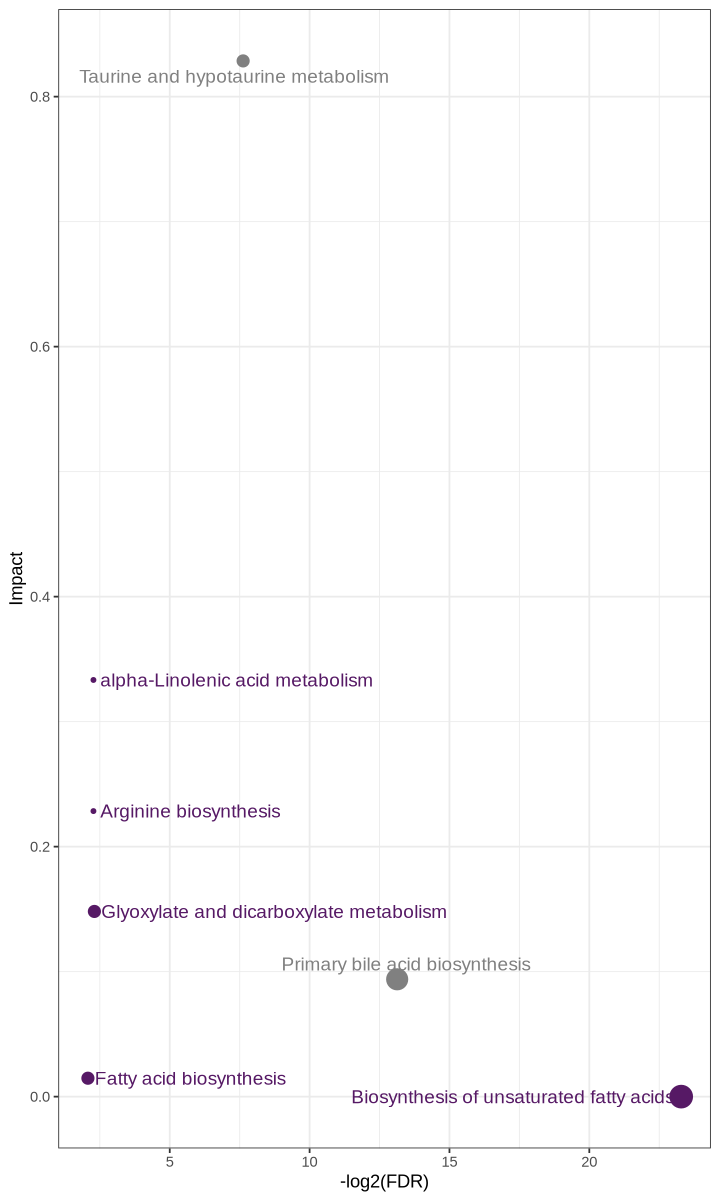

In [100]:
options(repr.plot.width = 6, repr.plot.height = 10)

ggplot(combined_pathways, aes(x = -log2(FDR), y = Impact, fill = X, color = source, size = Hits)) + geom_point() + 
        ggrepel::geom_text_repel(aes(label = X,  color = source), size = 4, force = 2) + theme_bw() + theme(legend.position = "none") +
        scale_color_manual(values = c("#808080", "#561965", "#87d662"))

## Prediction

In [101]:
library(pROC)

Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:IRanges’:

    cov, var


The following objects are masked from ‘package:S4Vectors’:

    cov, var


The following object is masked from ‘package:BiocGenerics’:

    var


The following objects are masked from ‘package:stats’:

    cov, smooth, var




In [106]:
pred_df <- SummarizedExperiment::assay(gp_se) %>% as.data.frame() %>% t() %>% as.data.frame() %>% tibble::rownames_to_column("owl_code") %>% select(owl_code, taurocholic_acid, aspartic_acid, tyrosine, pc_32_1) %>% left_join(., ann %>% dplyr::rename(owl_code = sample_description), by = "owl_code")

In [107]:
pred_df_cir <- pred_df %>% filter(!GRUPO == "sano") %>% mutate(ta_aa_ratio = taurocholic_acid/aspartic_acid, ty_aa_ratio = tyrosine/aspartic_acid, pc_aa_ratio = pc_32_1/aspartic_acid, ta_ty_ratio = taurocholic_acid/tyrosine, ta_pc_ratio = taurocholic_acid/pc_32_1, ty_pc_ratio = tyrosine/pc_32_1, aa_ta_ratio = aspartic_acid/taurocholic_acid, aa_ty_ratio = aspartic_acid/tyrosine, aa_pc_ratio = aspartic_acid/pc_32_1, ty_ta_ratio = tyrosine/taurocholic_acid, pc_ta_ratio = pc_32_1/taurocholic_acid, pc_ty_ratio = pc_32_1/tyrosine
) 
pred_df_healthy <- pred_df %>% filter(!GRUPO == "CIRROSIS") %>% mutate(ta_aa_ratio = taurocholic_acid/aspartic_acid, ty_aa_ratio = tyrosine/aspartic_acid, pc_aa_ratio = pc_32_1/aspartic_acid, ta_ty_ratio = taurocholic_acid/tyrosine, ta_pc_ratio = taurocholic_acid/pc_32_1, ty_pc_ratio = tyrosine/pc_32_1, aa_ta_ratio = aspartic_acid/taurocholic_acid, aa_ty_ratio = aspartic_acid/tyrosine, aa_pc_ratio = aspartic_acid/pc_32_1, ty_ta_ratio = tyrosine/taurocholic_acid, pc_ta_ratio = pc_32_1/taurocholic_acid, pc_ty_ratio = pc_32_1/tyrosine) 

In [108]:
names(pred_df_cir)

[1] "owl_code"         "taurocholic_acid" "aspartic_acid"    "tyrosine"        
 [5] "pc_32_1"          "GRUPO"            "ta_aa_ratio"      "ty_aa_ratio"     
 [9] "pc_aa_ratio"      "ta_ty_ratio"      "ta_pc_ratio"      "ty_pc_ratio"     
[13] "aa_ta_ratio"      "aa_ty_ratio"      "aa_pc_ratio"      "ty_ta_ratio"     
[17] "pc_ta_ratio"      "pc_ty_ratio"

In [109]:
roc_res_ta <- roc(response = pred_df_cir$GRUPO, predictor = pred_df_cir$taurocholic_acid, levels=c("CIRROSIS", "IPH"), direction = "<")
roc_res_aa <- roc(response = pred_df_cir$GRUPO, predictor = pred_df_cir$aspartic_acid, levels=c("CIRROSIS", "IPH"), direction = "<")
roc_res_t <- roc(response = pred_df_cir$GRUPO, predictor = pred_df_cir$tyrosine, levels=c("CIRROSIS", "IPH"), direction = "<")
roc_res_pc <- roc(response = pred_df_cir$GRUPO, predictor = pred_df_cir$pc_32_1, levels=c("CIRROSIS", "IPH"), direction = "<")
roc_res_ta_aa_ratio <- roc(response = pred_df_cir$GRUPO, predictor = pred_df_cir$ta_aa_ratio, levels=c("CIRROSIS", "IPH"), direction = "<")
roc_res_ty_aa_ratio <- roc(response = pred_df_cir$GRUPO, predictor = pred_df_cir$ty_aa_ratio, levels=c("CIRROSIS", "IPH"), direction = "<")
roc_res_pc_aa_ratio <- roc(response = pred_df_cir$GRUPO, predictor = pred_df_cir$pc_aa_ratio, levels=c("CIRROSIS", "IPH"), direction = "<")
roc_res_ta_ty_ratio <- roc(response = pred_df_cir$GRUPO, predictor = pred_df_cir$ta_ty_ratio, levels=c("CIRROSIS", "IPH"), direction = "<")
roc_res_ta_pc_ratio <- roc(response = pred_df_cir$GRUPO, predictor = pred_df_cir$ta_pc_ratio, levels=c("CIRROSIS", "IPH"), direction = "<")
roc_res_ty_pc_ratio <- roc(response = pred_df_cir$GRUPO, predictor = pred_df_cir$ty_pc_ratio, levels=c("CIRROSIS", "IPH"), direction = "<")
roc_res_aa_ta_ratio <- roc(response = pred_df_cir$GRUPO, predictor = pred_df_cir$aa_ta_ratio, levels=c("CIRROSIS", "IPH"), direction = "<")
roc_res_aa_ty_ratio <- roc(response = pred_df_cir$GRUPO, predictor = pred_df_cir$aa_ty_ratio, levels=c("CIRROSIS", "IPH"), direction = "<")
roc_res_aa_pc_ratio <- roc(response = pred_df_cir$GRUPO, predictor = pred_df_cir$aa_pc_ratio, levels=c("CIRROSIS", "IPH"), direction = "<")
roc_res_ty_ta_ratio <- roc(response = pred_df_cir$GRUPO, predictor = pred_df_cir$ty_ta_ratio, levels=c("CIRROSIS", "IPH"), direction = "<")
roc_res_pc_ta_ratio <- roc(response = pred_df_cir$GRUPO, predictor = pred_df_cir$pc_ta_ratio, levels=c("CIRROSIS", "IPH"), direction = "<")
roc_res_pc_ty_ratio <- roc(response = pred_df_cir$GRUPO, predictor = pred_df_cir$pc_ty_ratio, levels=c("CIRROSIS", "IPH"), direction = "<")

In [110]:
roc_res_h_ta <- roc(response = pred_df_healthy$GRUPO, predictor = pred_df_healthy$taurocholic_acid, levels=c("sano", "IPH"), direction = "<")
roc_res_h_aa <- roc(response = pred_df_healthy$GRUPO, predictor = pred_df_healthy$aspartic_acid, levels=c("sano", "IPH"), direction = "<")
roc_res_h_t <- roc(response = pred_df_healthy$GRUPO, predictor = pred_df_healthy$tyrosine, levels=c("sano", "IPH"), direction = "<")
roc_res_h_pc <- roc(response = pred_df_healthy$GRUPO, predictor = pred_df_healthy$pc_32_1, levels=c("sano", "IPH"), direction = "<")
roc_res_h_ta_aa_ratio <- roc(response = pred_df_healthy$GRUPO, predictor = pred_df_healthy$ta_aa_ratio, levels=c("sano", "IPH"), direction = "<")
roc_res_h_ty_aa_ratio <- roc(response = pred_df_healthy$GRUPO, predictor = pred_df_healthy$ty_aa_ratio, levels=c("sano", "IPH"), direction = "<")
roc_res_h_pc_aa_ratio <- roc(response = pred_df_healthy$GRUPO, predictor = pred_df_healthy$pc_aa_ratio, levels=c("sano", "IPH"), direction = "<")
roc_res_h_ta_ty_ratio <- roc(response = pred_df_healthy$GRUPO, predictor = pred_df_healthy$ta_ty_ratio, levels=c("sano", "IPH"), direction = "<")
roc_res_h_ta_pc_ratio <- roc(response = pred_df_healthy$GRUPO, predictor = pred_df_healthy$ta_pc_ratio, levels=c("sano", "IPH"), direction = "<")
roc_res_h_ty_pc_ratio <- roc(response = pred_df_healthy$GRUPO, predictor = pred_df_healthy$ty_pc_ratio, levels=c("sano", "IPH"), direction = "<")
roc_res_h_aa_ta_ratio <- roc(response = pred_df_healthy$GRUPO, predictor = pred_df_healthy$aa_ta_ratio, levels=c("sano", "IPH"), direction = "<")
roc_res_h_aa_ty_ratio <- roc(response = pred_df_healthy$GRUPO, predictor = pred_df_healthy$aa_ty_ratio, levels=c("sano", "IPH"), direction = "<")
roc_res_h_aa_pc_ratio <- roc(response = pred_df_healthy$GRUPO, predictor = pred_df_healthy$aa_pc_ratio, levels=c("sano", "IPH"), direction = "<")
roc_res_h_ty_ta_ratio <- roc(response = pred_df_healthy$GRUPO, predictor = pred_df_healthy$ty_ta_ratio, levels=c("sano", "IPH"), direction = "<")
roc_res_h_pc_ta_ratio <- roc(response = pred_df_healthy$GRUPO, predictor = pred_df_healthy$pc_ta_ratio, levels=c("sano", "IPH"), direction = "<")
roc_res_h_pc_ty_ratio <- roc(response = pred_df_healthy$GRUPO, predictor = pred_df_healthy$pc_ty_ratio, levels=c("sano", "IPH"), direction = "<")

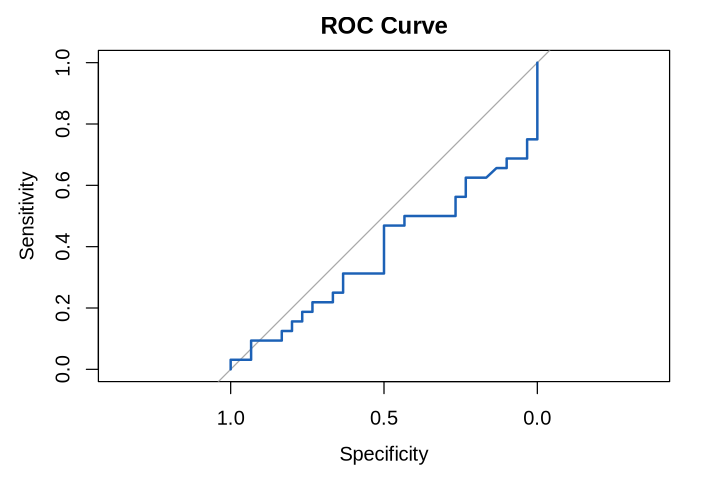

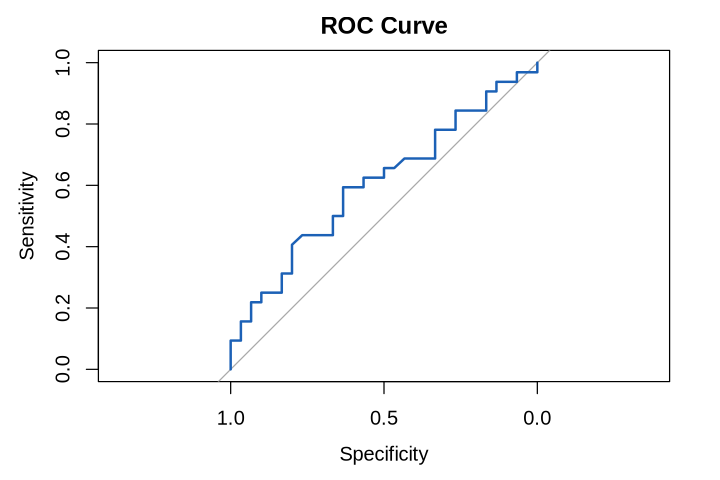

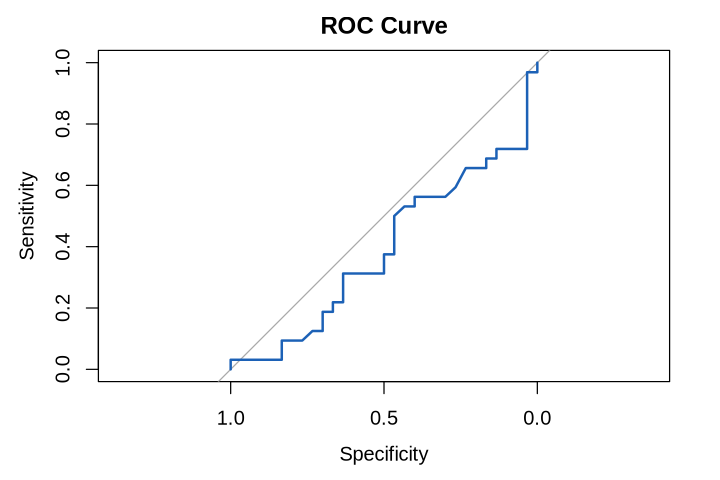

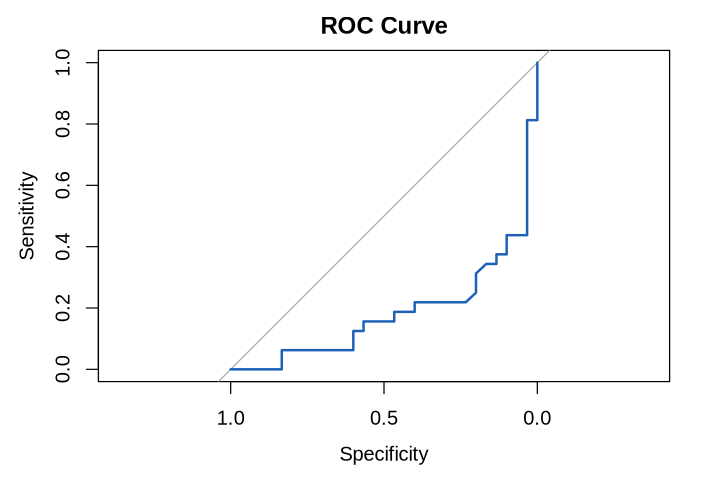

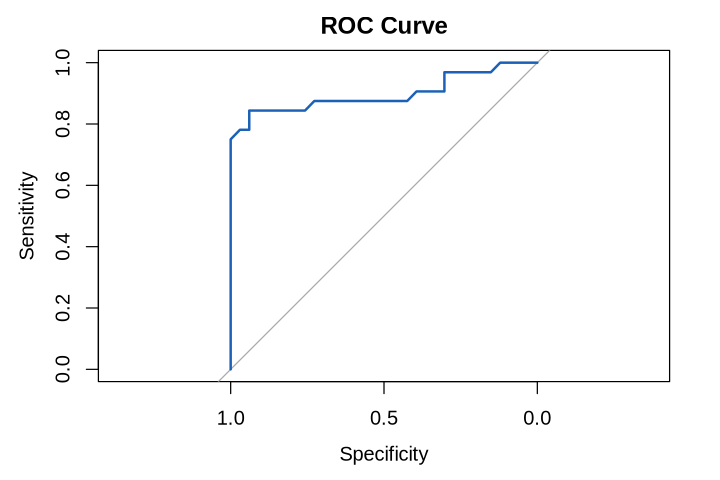

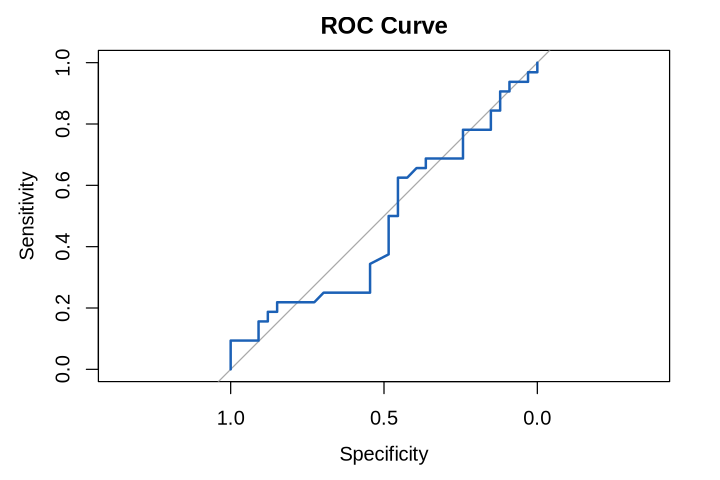

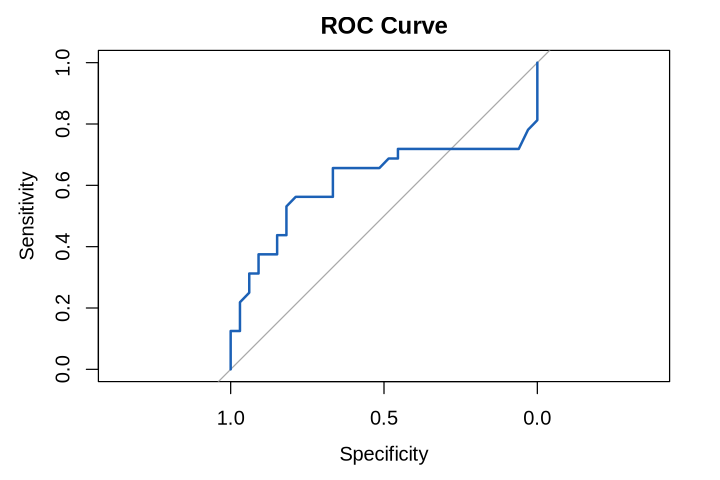

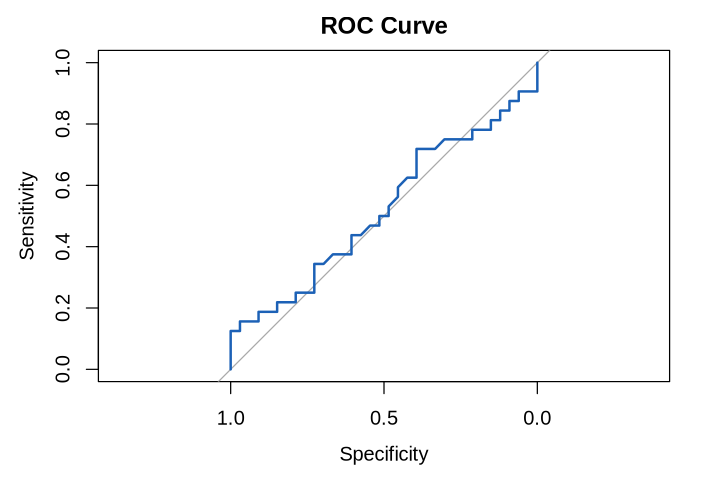

In [117]:
options(repr.plot.width = 6, repr.plot.height = 4)

plot(roc_res_ta, main="ROC Curve", col="#1c61b6")
plot(roc_res_aa, main="ROC Curve", col="#1c61b6")
plot(roc_res_t, main="ROC Curve", col="#1c61b6")
plot(roc_res_pc, main="ROC Curve", col="#1c61b6")

plot(roc_res_h_ta, main="ROC Curve", col="#1c61b6")
plot(roc_res_h_aa, main="ROC Curve", col="#1c61b6")
plot(roc_res_h_t, main="ROC Curve", col="#1c61b6")
plot(roc_res_h_pc, main="ROC Curve", col="#1c61b6")

In [112]:
roc_list <- list("ROC_PSVD_CIR_TA" = roc_res_ta,"ROC_PSVD_CIR_AA" = roc_res_aa,
                  "ROC_PSVD_CIR_T" = roc_res_t, "ROC_PSVD_CIR_PC" = roc_res_pc, 
                  "ROC_PSVD_H_TA" = roc_res_h_ta, "ROC_PSVD_H_AA" = roc_res_h_aa,
                  "ROC_PSVD_H_T" = roc_res_h_t, "ROC_PSVD_H_PC" = roc_res_h_pc,
                  "ROC_PSVD_CIR_TA_AA_RATIO" = roc_res_ta_aa_ratio, "ROC_PSVD_CIR_TY_AA_RATIO" = roc_res_ty_aa_ratio,
                  "ROC_PSVD_CIR_PC_AA_RATIO" = roc_res_pc_aa_ratio, "ROC_PSVD_CIR_TA_TY_RATIO" = roc_res_ta_ty_ratio,
                  "ROC_PSVD_CIR_TA_PC_RATIO" = roc_res_ta_pc_ratio, "ROC_PSVD_CIR_TY_PC_RATIO" = roc_res_ty_pc_ratio,
                  "ROC_PSVD_CIR_AA_TA_RATIO" = roc_res_aa_ta_ratio, "ROC_PSVD_CIR_AA_TY_RATIO" = roc_res_aa_ty_ratio,
                  "ROC_PSVD_CIR_AA_PC_RATIO" = roc_res_aa_pc_ratio, "ROC_PSVD_CIR_TY_TA_RATIO" = roc_res_ty_ta_ratio,
                  "ROC_PSVD_CIR_PC_TA_RATIO" = roc_res_pc_ta_ratio, "ROC_PSVD_CIR_PC_TY_RATIO" = roc_res_pc_ty_ratio,
                  "ROC_PSVD_H_TA_AA_RATIO" = roc_res_h_ta_aa_ratio, "ROC_PSVD_H_TY_AA_RATIO" = roc_res_h_ty_aa_ratio,
                  "ROC_PSVD_H_PC_AA_RATIO" = roc_res_h_pc_aa_ratio, "ROC_PSVD_H_TA_TY_RATIO" = roc_res_h_ta_ty_ratio,
                  "ROC_PSVD_H_TA_PC_RATIO" = roc_res_h_ta_pc_ratio, "ROC_PSVD_H_TY_PC_RATIO" = roc_res_h_ty_pc_ratio,
                  "ROC_PSVD_H_AA_TA_RATIO" = roc_res_h_aa_ta_ratio, "ROC_PSVD_H_AA_TY_RATIO" = roc_res_h_aa_ty_ratio,
                  "ROC_PSVD_H_AA_PC_RATIO" = roc_res_h_aa_pc_ratio, "ROC_PSVD_H_TY_TA_RATIO" = roc_res_h_ty_ta_ratio,
                  "ROC_PSVD_H_PC_TA_RATIO" = roc_res_h_pc_ta_ratio, "ROC_PSVD_H_PC_TY_RATIO" = roc_res_h_pc_ty_ratio)

results <- lapply(roc_list, function(roc_obj) {
  auc_value <- auc(roc_obj)
  auc_ci <- ci(roc_obj)
  
  ci_lower <- auc_ci[1]
  ci_upper <- auc_ci[3]
  
  c(AUC=auc_value, CI_lower=ci_lower, CI_upper=ci_upper)
})

results_df <- do.call(rbind, results)
rownames(results_df) <- names(roc_list)

In [113]:
results_df %>% as.data.frame %>% arrange(desc(AUC))

,AUC,CI_lower,CI_upper
,<dbl>,<dbl>,<dbl>
ROC_PSVD_H_TA,0.8986742,0.81213304,0.9852154
ROC_PSVD_CIR_TA_AA_RATIO,0.7197917,0.59231070,0.8472726
ROC_PSVD_H_TA_AA_RATIO,0.6448864,0.50646131,0.7833114
ROC_PSVD_CIR_TY_AA_RATIO,0.6312500,0.49148802,0.7710120
ROC_PSVD_CIR_TY_TA_RATIO,0.6197917,0.47915117,0.7604322
ROC_PSVD_H_T,0.6117424,0.46113700,0.7623479
ROC_PSVD_CIR_AA,0.6052083,0.46293490,0.7474818
ROC_PSVD_H_TY_AA_RATIO,0.5823864,0.44037828,0.7243944
ROC_PSVD_CIR_AA_TA_RATIO,0.5760417,0.42912252,0.7229608


### Final plots

In [114]:
roc_df_cir <- data.frame(
  specificity = rev(roc_res_ta_aa_ratio$specificities),
  sensitivity = rev(roc_res_ta_aa_ratio$sensitivities)
)


roc_df_hc <- data.frame(
  specificity = rev(roc_res_h_ta$specificities),
  sensitivity = rev(roc_res_h_ta$sensitivities)
)

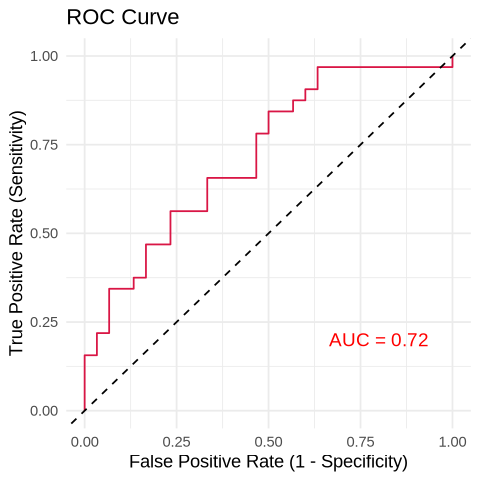

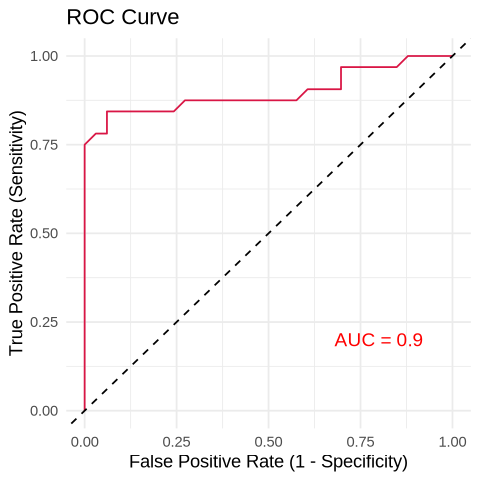

In [115]:
options(repr.plot.width = 4, repr.plot.height = 4)

ggplot(roc_df_cir, aes(x = 1 - specificity, y = sensitivity)) + 
  geom_line(color = "#d91645") +
  geom_abline(linetype = "dashed") +
  labs(x = "False Positive Rate (1 - Specificity)", y = "True Positive Rate (Sensitivity)", 
       title = "ROC Curve") +
  theme_minimal() +
  annotate("text", x = 0.8, y = 0.2, label = paste("AUC =", round(auc(roc_res_ta_aa_ratio), 2)), 
           size = 4, color = "red")

ggplot(roc_df_hc, aes(x = 1 - specificity, y = sensitivity)) + 
  geom_line(color = "#d91645") + # ROC curve
  geom_abline(linetype = "dashed") + # Diagonal line
  labs(x = "False Positive Rate (1 - Specificity)", y = "True Positive Rate (Sensitivity)", 
       title = "ROC Curve") +
  theme_minimal() +
  annotate("text", x = 0.8, y = 0.2, label = paste("AUC =", round(auc(roc_res_h_ta), 2)), 
           size = 4, color = "red")


In [ ]:
ggplot(roc_df, aes(x = specificity, y = sensitivity)) +
  geom_line(color = "#1c61b6") + # ROC curve
  geom_abline(linetype = "dashed") + # Diagonal line
  labs(x = "1 - Specificity (False Positive Rate)", y = "Sensitivity (True Positive Rate)", 
       title = "ROC Curve") +
  theme_minimal() +
  annotate("text", x = 0.7, y = 0.3, label = paste("AUC =", round(auc(roc_res_ta_aa_ratio), 2)), 
           size = 4, color = "red")


## Outputs

In [ ]:
is.na(meta_gp$INDIVIDUAL.NOTATION ) <- meta_gp$INDIVIDUAL.NOTATION  == ""

In [ ]:
meta_gp$INDIVIDUAL.NOTATION <- janitor::make_clean_names(meta_gp$INDIVIDUAL.NOTATION)

In [ ]:
mapped_meta <- meta_gp %>% select(c(INDIVIDUAL.NOTATION, HMBD)) %>% rename(ID = INDIVIDUAL.NOTATION)

In [ ]:
iph_cirrhosis_map <- left_join(iph_cirrhosis, mapped_meta, by = "ID")
iph_sano_map <- left_join(iph_sano, mapped_meta, by = "ID")

In [ ]:
write.csv(iph_cirrhosis, "outputs/06_iph_cirrhosis.csv")
write.csv(iph_sano, "outputs/06_iph_sano.csv")

In [ ]:
write.csv(metabolites_gp, "outputs/06_metabolites_mapped.csv")

In [ ]:
write.csv(mtx_norm, "outputs/06_metabolites_normalized.csv")

In [ ]:
write.csv(iph_cirrhosis_map, "outputs/06_iph_cirrhosis_map.csv")
write.csv(iph_sano_map, "outputs/06_iph_sano_map.csv")